# Predicting Modeling Census 2011 in UK

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('../Conundrum7/Conundrum7Data.csv')
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(keep='first', inplace=True)

# Prediction of work status

Let's build a model to predict if every person is currently in work - either Employed or Self-Employed.

In [3]:
df_ml = df.copy()

In [4]:
df_ml.dtypes

Person ID                     int64
Region                       object
Residence Type               object
Family Composition            int64
Population Base               int64
Sex                           int64
Age                           int64
Marital Status                int64
Student                       int64
Country of Birth              int64
Health                        int64
Ethnic Group                  int64
Religion                      int64
Economic Activity             int64
Occupation                    int64
Industry                      int64
Hours worked per week         int64
Approximated Social Grade     int64
dtype: object

Converting `Region` and `Residence Type` to categorical variables:

In [5]:
df_ml['Region'] = df_ml['Region'].astype('category').cat.codes
df_ml['Residence Type'] = df_ml['Residence Type'].astype('category').cat.codes

In [6]:
df_ml.head()

,Person ID,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
0,7394816,0,1,2,1,2,6,2,2,1,2,1,2,5,8,2,-9,4
1,7394745,0,1,5,1,1,4,1,2,1,1,1,2,1,8,6,4,3
2,7395066,0,1,3,1,2,4,1,2,1,1,1,1,1,6,11,3,4
3,7395329,0,1,3,1,2,2,1,2,1,2,1,2,1,7,7,3,2
4,7394712,0,1,3,1,1,5,4,2,1,1,1,2,1,1,4,3,2


According to the codification of `Economy Activity`, cluster 1 and 2 belongs to Employed and Self-employed. We labeled them together as **work status=1**. Then, the rest of `Economy Activity`, clusters belong to the **work status=0**.

In [7]:
def work_status(activity_column):
    if activity_column in [1,2]:
        return 1
    else:
        return 0

In [8]:
df_ml['work_status'] = df_ml['Economic Activity'].apply(work_status)

In [9]:
df_ml.groupby('work_status').count()

,Person ID,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
work_status,,,,,,,,,,,,,,,,,,
0,313084,313084,313084,313084,313084,313084,313084,313084,313084,313084,313084,313084,313084,313084,313084,313084,313084,313084
1,256657,256657,256657,256657,256657,256657,256657,256657,256657,256657,256657,256657,256657,256657,256657,256657,256657,256657


Defining the column `work_status` as the output and the rest of columns (except by `Person ID`, `Economic Activity`, that was used to generate the output labels and `Hours worked per week` that is directly related to the work status) as the components of the feature vectors,

In [10]:
y = df_ml['work_status']
df_ml.drop(columns=['Person ID', 'Economic Activity', 'Hours worked per week', 'work_status'], inplace=True)

Replacing negative codes, 

In [11]:
X = df_ml.replace({-9:0})

Splitting samples between training and testing:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Applying the Categorical Naive Bayes Model:

In [13]:
clf = CategoricalNB()
clf.fit(X_train, y_train)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
y_pred = clf.predict(X_test)

Evaluating the model:

In [15]:
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.8232853761667952


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.70      0.81    103077
           1       0.73      0.98      0.83     84938

    accuracy                           0.82    188015
   macro avg       0.85      0.84      0.82    188015
weighted avg       0.86      0.82      0.82    188015



In [17]:
confusion_matrix(y_test, y_pred)

array([[71789, 31288],
       [ 1937, 83001]])

## Feature Selection

Feature selection can help us to avoid overfitting, increase the accuracy of the model and reduction of training time. In this section, we try to get the same or better model performance avoiding misleading data that are not offering significant information to the problem using two automatic feature selection techniques: **Univariate Selection (ANOVA f-value method)** and **Feature Importance through ExtraTreesClassifier**. 

Importing packages from `sklearn`:

In [18]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_curve
from numpy import set_printoptions

In [19]:
print('Number of original features: {}'.format(X.shape[1]))

Number of original features: 15


### 1. ExtraTreesClassifier

**Extra Trees Classifier** is a type of ensemble learning similar to Random Forest, except by the manner of construction of the decision trees in the forest: instead of computing the locally optimal feature/split combination (for the random forest), for each feature under consideration, a random value is selected for the split (for the extra trees). In consequence, more diversified trees are generated and that leads less splitters to evaluate when training the trees.  Therefore, extra trees are faster than random forest and it reaches higher performance in presence of noisy features.

In [20]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [21]:
extraTreesClassifier = pd.DataFrame({'feature_importance': model.feature_importances_}, 
                       index=X.columns).sort_values('feature_importance', ascending=False)

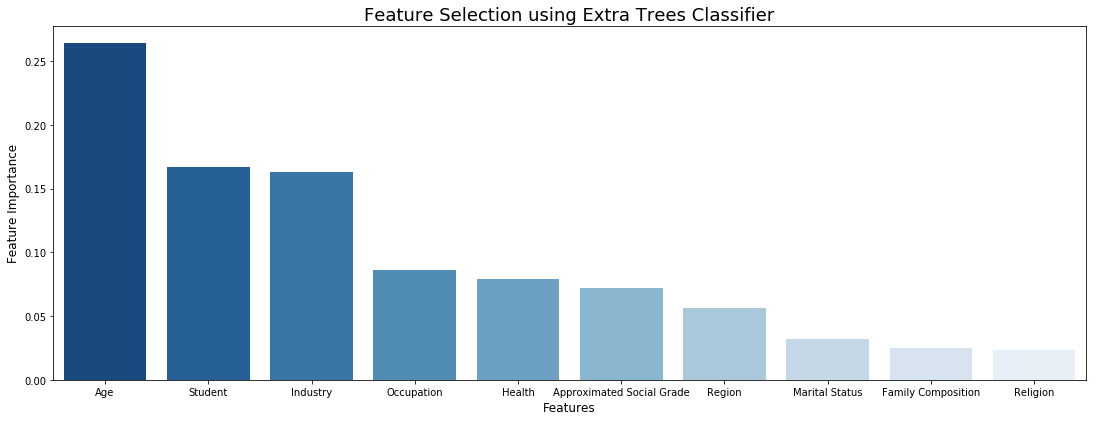

In [22]:
fig = plt.figure(figsize=(18.5, 6.5))
_ = sns.barplot(x=extraTreesClassifier.index[:10], y=extraTreesClassifier.feature_importance[:10], palette='Blues_r')
_ = plt.title('Feature Selection using Extra Trees Classifier', size=18)
_ = plt.ylabel('Feature Importance', size=12)
_ = plt.xlabel('Features', size=12)

### 2. SelectKBest

F-test is appropiated for numerical and categorical data.

In [23]:
test = SelectKBest(score_func=f_classif, k=15)
fit = test.fit(X, y)
# summarize scores
set_printoptions(precision=3)

In [24]:
selectkbest = pd.DataFrame({'feature_score': fit.scores_}, index=X.columns).sort_values('feature_score', ascending=False)

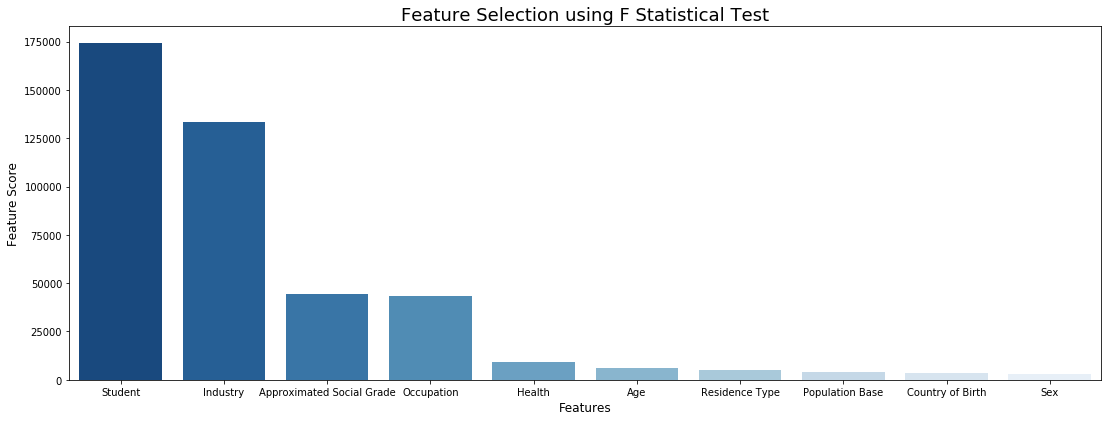

In [25]:
fig = plt.figure(figsize=(18.5, 6.5))
_ = sns.barplot(x=selectkbest.index[:10], y=selectkbest.feature_score[:10], palette='Blues_r')
_ = plt.title('Feature Selection using F-Statistical Test', size=18)
_ = plt.ylabel('Feature Score', size=12)
_ = plt.xlabel('Features', size=12)

Let's select `Student`, `Industry`, `Approximated Social Grade`, `Occupation`, `Health`, `Age` seem to be the features more related to the work status. 

In [26]:
X_fselection = df_ml.loc[:, ['Student', 'Industry', 'Approximated Social Grade', 'Occupation', 'Health', 'Age']].replace({-9:0})

In [27]:
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_fselection, y, test_size=0.33, random_state=42)

In [28]:
clf = CategoricalNB()
clf.fit(X_trainfs, y_trainfs)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
y_predfs = clf.predict(X_testfs)

In [30]:
print('Accuracy: {}'.format(accuracy_score(y_testfs, y_predfs)))

Accuracy: 0.8355982235459937


In [31]:
print(classification_report(y_testfs, y_predfs))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83    103077
           1       0.74      0.98      0.84     84938

    accuracy                           0.84    188015
   macro avg       0.86      0.85      0.84    188015
weighted avg       0.87      0.84      0.83    188015



In [32]:
confusion_matrix(y_testfs, y_predfs)

array([[73834, 29243],
       [ 1667, 83271]])

In [33]:
accuracy = accuracy_score(y_test, y_pred)
accuracy_featureSelection = accuracy_score(y_testfs, y_predfs)
print('Improvement: {:.2f}%'.format(100*(accuracy_featureSelection-accuracy)/accuracy))

Improvement: 1.50%


The performance of the model increased 1.5% in accuracy and now we are using only 1/3 of the features, selecting the columns `Student`, `Industry`, `Approximated Social Grade`, `Occupation`, `Health` and `Age` as the most useful to the predictive modeling.